## Stokes back rotation

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import scipy.io
from numpy.linalg import norm
import math
#import seaborn as sns; sns.set()

###  Functions for Stokes vector rotation

In [2]:
def find_angle_axis(s, s_base = np.array([0, 0, 1])):
    c = np.dot(s_base,s)/norm(s)/norm(s_base) 
    theta = np.arccos(np.clip(c, -1, 1))
    axis = np.cross(s_base, s)
    axis = axis/norm(axis)
    return [theta, axis]

def rotate_Stokes(s1, s2, s3, theta, axis):
    ux, uy, uz = axis
    s = np.array([s1, s2, s3])
    a11 = np.cos(theta) + ux**2*(1-np.cos(theta))
    a12 = ux*uy*(1 - np.cos(theta)) - uz*np.sin(theta)
    a13 = ux*uz*(1 - np.cos(theta)) + uy*np.sin(theta)
    
    a21 = ux*uy*(1 - np.cos(theta)) + uz*np.sin(theta)
    a22 = np.cos(theta) + uy**2*(1-np.cos(theta))
    a23 = uy*uz*(1 - np.cos(theta)) -ux*np.sin(theta)
    
    a31 = ux*uz*(1 - np.cos(theta)) -uy*np.sin(theta)
    a32 = uy*uz*(1 - np.cos(theta)) + ux*np.sin(theta)
    a33 = np.cos(theta) + uz**2*(1 - np.cos(theta))
    stokes_rot = np.matrix([[a11, a12, a13], 
                             [a21, a22, a23], 
                             [a31, a32, a33]])

    stokes_rot = stokes_rot.T
    s_b = np.dot(stokes_rot, s)
    s1_b, s2_b, s3_b = s_b[0, 0], s_b[0, 1], s_b[0, 2]
    return [s1_b, s2_b, s3_b]

### Visualize the different SOP traces generated by same Robot Arm Movement
In the following, we plot some of the sample traces generated by robot arm movement type 2

number of sample  4 , dimension: 3 , time steps: 10000


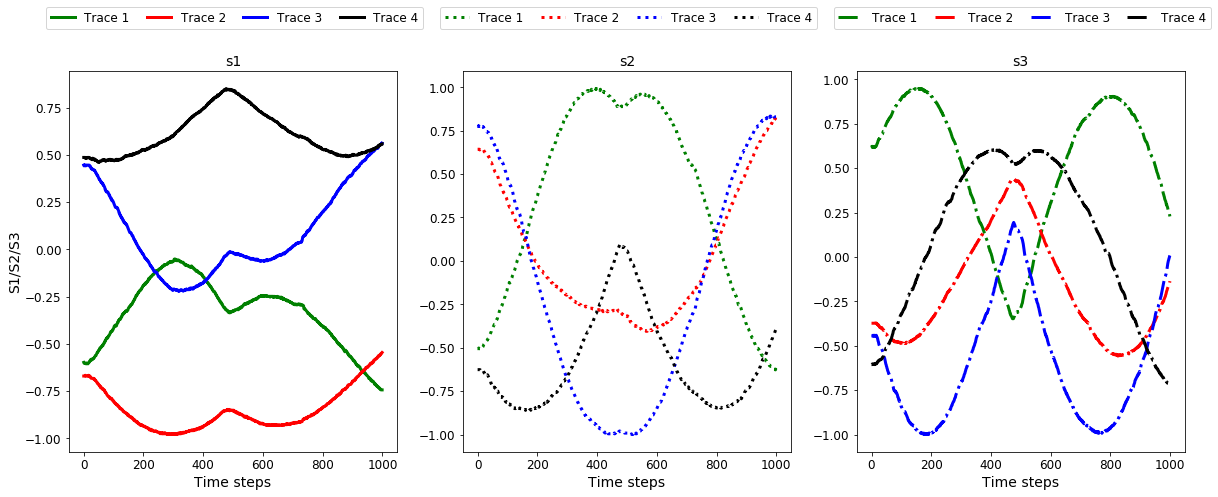

In [3]:
data = np.load('mvt_2_samp.npz')
arr = data['X']
num_samples, dim, steps = arr.shape
print('number of sample ', num_samples, ', dimension:', dim, ', time steps:', steps)
# plot sample of traces for a given movement
color =['g', 'r', 'b', 'k']
line = ['', ':', '-.']
plt.figure(figsize=(20, 7))
plt.legend(['Trace 1','Trace 2', 'Trace 3', 'Trace 4'],
           fontsize = 18,
          bbox_to_anchor=(-0.07, 1.01, 1.15, .102), loc=4,
       ncol=4, mode="expand", borderaxespad=0.)
plt.grid()
for s in range(3): # loop through each dimenson (s1, s2, s3)
    plt.subplot(1, 3, s + 1)
    for i in range(num_samples):
        plt.plot(arr[i, s, ::10], color[i] + line[s], linewidth =3)
    plt.title('s'+str(s+1), fontsize = 14)    
    plt.xlabel('Time steps', fontsize = 14)
    plt.legend(['Trace 1','Trace 2', 'Trace 3', 'Trace 4'],
           fontsize = 12,
          bbox_to_anchor=(-0.07, 1.11, 1.15, .102), loc=4,
       ncol=4, mode="expand", borderaxespad=0.)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
   
    if s == 0:
        plt.ylabel('S1/S2/S3', fontsize = 14)
plt.show()

### Carry out back rotation 

In [4]:

arr_rot = np.zeros([num_samples, dim, steps])
for i in range(num_samples):
    s1_r, s2_r, s3_r = arr[i, 0, 0], arr[i, 1, 0], arr[i, 2, 0]
    # Chose the starting point as [0, -1, 0]
    s_base = np.array([0, -1, 0])
    theta, axis = find_angle_axis(np.array([s1_r, s2_r, s3_r]), s_base)  

    for stp in range(steps):
        s1, s2, s3 = arr[i, 0, stp], arr[i, 1, stp], arr[i, 2, stp]
        [s1_b, s2_b, s3_b] = rotate_Stokes(s1, s2, s3, theta, axis)
        arr_rot[i, 0, stp],  arr_rot[i, 1, stp], arr_rot[i, 2, stp] = s1_b, s2_b, s3_b 

### Plot the rotated traces
Note that every trace has a starting point, eg, s1= 0, s2 = -1, and s3 = 0

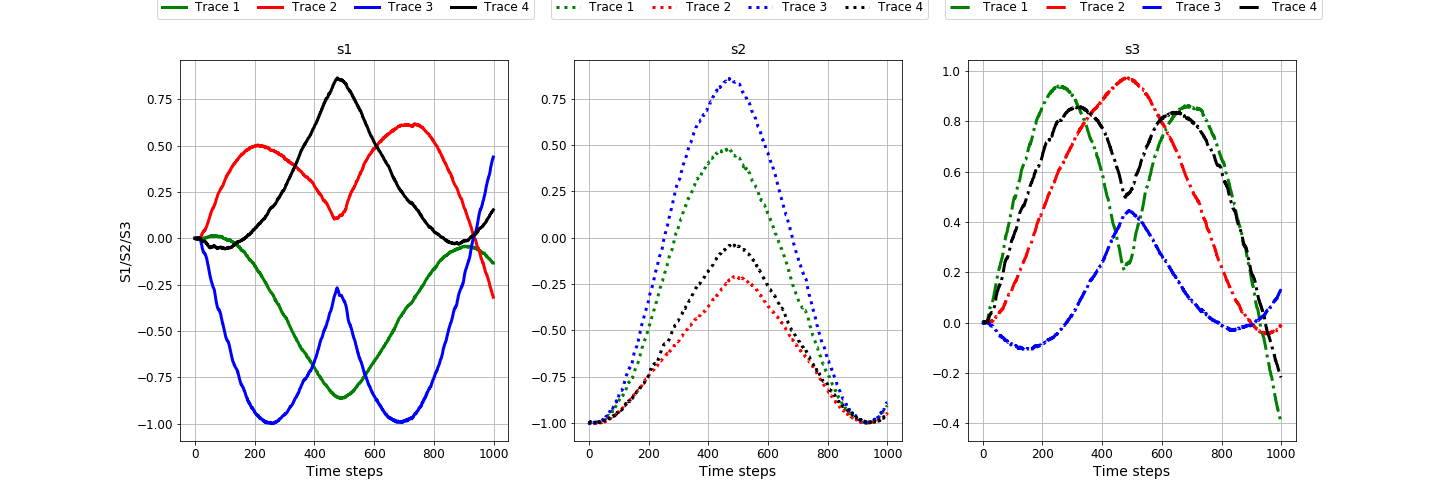

In [8]:
color =['g', 'r', 'b', 'k']
line = ['', ':', '-.']
plt.figure(figsize=(20, 7))
plt.legend(['Trace 1','Trace 2', 'Trace 3', 'Trace 4'],
           fontsize = 18,
          bbox_to_anchor=(-0.07, 1.01, 1.15, .102), loc=4,
       ncol=4, mode="expand", borderaxespad=0.)

for s in range(3): # loop through each dimenson (s1, s2, s3)
    plt.subplot(1, 3, s + 1)
    for i in range(num_samples):
        plt.plot(arr_rot[i, s, ::10], color[i] + line[s], linewidth =3)
    plt.title('s'+str(s+1), fontsize = 14)    
    plt.xlabel('Time steps', fontsize = 14)
    plt.legend(['Trace 1','Trace 2', 'Trace 3', 'Trace 4'],
           fontsize = 12,
          bbox_to_anchor=(-0.07, 1.11, 1.15, .102), loc=4,
       ncol=4, mode="expand", borderaxespad=0.)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
   
    if s == 0:
        plt.ylabel('S1/S2/S3', fontsize = 14)
    plt.grid()        
plt.show()

### Plot the same set of rotated traces on Poincare Sphere
In the following, we plot the raotated traces of Movement II on a Poincare Sphere. Note that the start of the trace is marked by a diamond symbol and the end is marked by a square symbol.

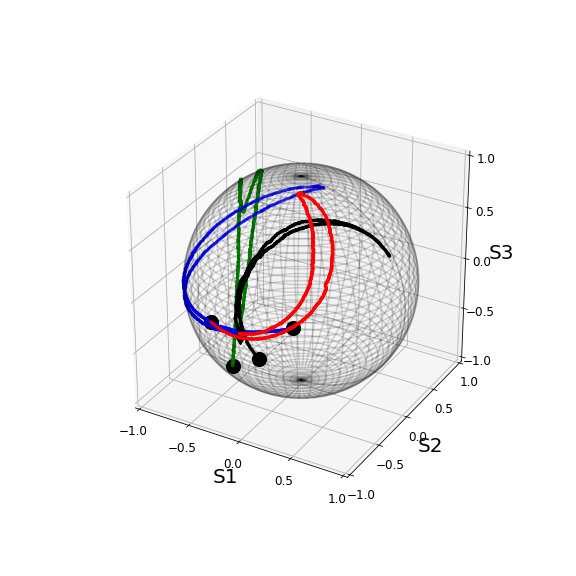

In [6]:
# Plot 
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, color='black', alpha =0.15)

# Plot the traces
for i in range(num_samples):
    xx = arr_rot[i, 0, :]
    xx = xx[::10] # down-sampling by a factor of 20
    yy = arr_rot[i, 1, :]
    yy = yy[::10]
    zz = arr_rot[i, 2, :]
    zz = zz[::10]
    ax.scatter(xx[-1],yy[-1],zz[-1],c='k',  s = 200, marker = 'o') # end of the trace
    ax.scatter(xx[0],yy[0],zz[0], c='k', s = 200, marker = 'd')  # start of the trace    
    if i == 0:
        ax.scatter(xx,yy,zz,c='g', s= 5)
    elif i == 1:
        ax.scatter(xx,yy,zz,c='r', s= 5)
    elif i == 2:
        ax.scatter(xx,yy,zz,c='b', s= 5)
    elif i == 3:    
        ax.scatter(xx,yy,zz,c='k', s= 5)
    else:
        ax.scatter(xx, yy, zz, s = 5)

# Format the axis:        
ax.tick_params(axis="x", labelsize = 12)
ax.tick_params(axis="y", labelsize = 12)
ax.tick_params(axis="z", labelsize = 12)     
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.set_xlabel('S1', fontsize = 20)
ax.set_ylabel('S2', fontsize = 20)
ax.set_zlabel('S3', fontsize = 20)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.show()